In [1]:
%%capture
%pip -q install "transformers>=4.43" "trl>=0.9.6" "peft>=0.11.1" "accelerate>=0.33" "datasets>=2.19"


#Importing Libraries

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

#Setting up platform

In [3]:
base_model = "NousResearch/Llama-2-7b-chat-hf" # Base model for tuning
guanaco_dataset = "mlabonne/guanaco-llama2-1k" # Dataset for tuning
new_model = "llama-2-7b-chat-guanaco" # New model we will get

# Loading the dataset

In [4]:
dataset = load_dataset(guanaco_dataset, split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [6]:
print(dataset[0])

{'text': '<s>[INST] Me gradué hace poco de la carrera de medicina ¿Me podrías aconsejar para conseguir rápidamente un puesto de trabajo? [/INST] Esto vale tanto para médicos como para cualquier otra profesión tras finalizar los estudios aniversarios y mi consejo sería preguntar a cuántas personas haya conocido mejor. En este caso, mi primera opción sería hablar con otros profesionales médicos, echar currículos en hospitales y cualquier centro de salud. En paralelo, trabajaría por mejorar mi marca personal como médico mediante un blog o formas digitales de comunicación como los vídeos. Y, para mejorar las posibilidades de encontrar trabajo, también participaría en congresos y encuentros para conseguir más contactos. Y, además de todo lo anterior, seguiría estudiando para presentarme a las oposiciones y ejercer la medicina en el sector público de mi país. </s>'}


#4-bit quantization configuration

4-bit quantization via QLoRA allows efficient finetuning of huge LLM models on consumer hardware while retaining high performance. This dramatically improves accessibility and usability for real-world applications.

QLoRA quantizes a pre-trained language model to 4 bits and freezes the parameters. A small number of trainable Low-Rank Adapter layers are then added to the model.

During fine-tuning, gradients are backpropagated through the frozen 4-bit quantized model into only the Low-Rank Adapter layers. So, the entire pretrained model remains fixed at 4 bits while only the adapters are updated. Also, the 4-bit quantization does not hurt model performance.



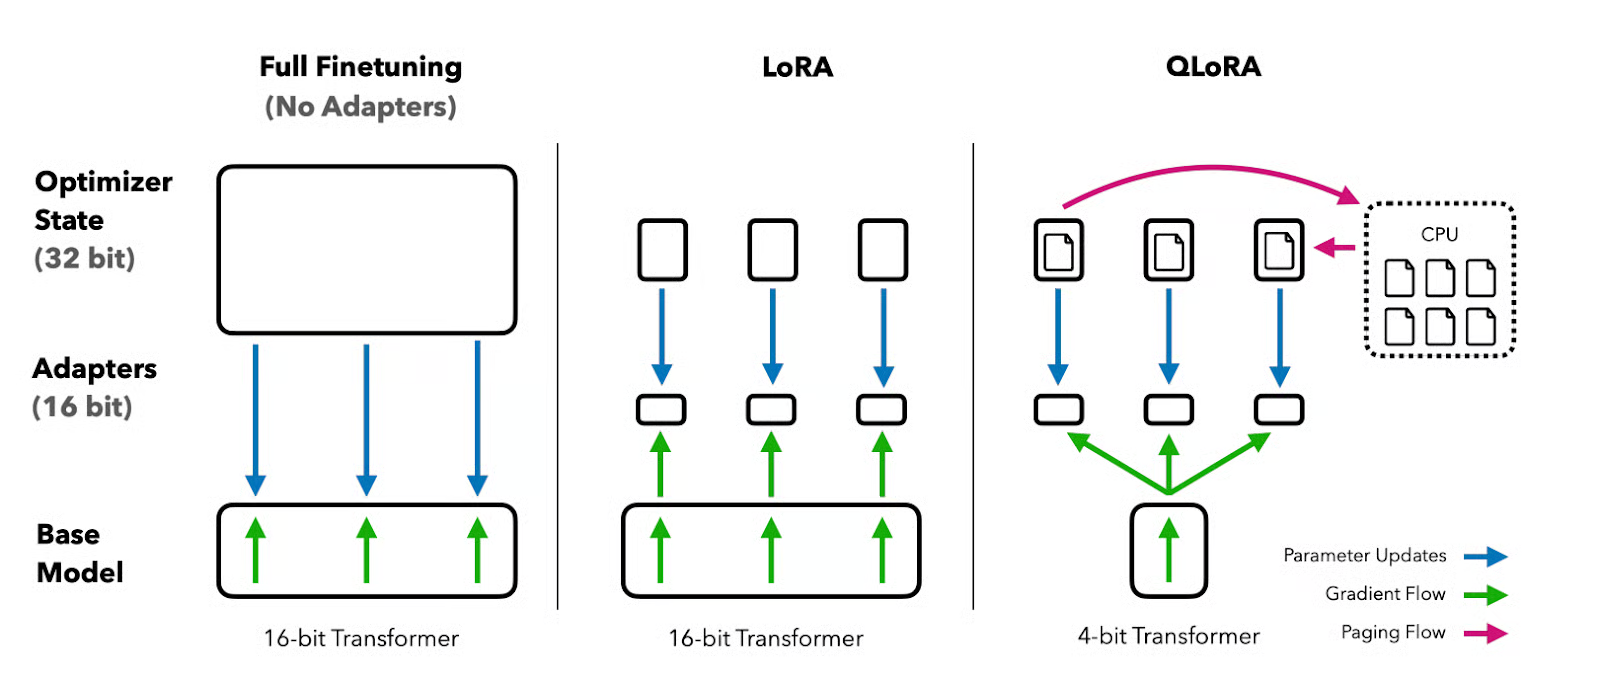

In [7]:
compute_dtype = getattr(torch, "float16")

# Below is the bits and bytes parameter tuning
quant_config = BitsAndBytesConfig(
    load_in_4bit=True, # Quantization process reducing float16 bit to 4 bit
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

# Loading llama 2 model

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Loading tokenizer

In [9]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# PEFT(Parameter-Efficient Fine-Tuning (PEFT))  parameters

In [10]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

#Training parameters

In [11]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

# Model fine-tuning

Supervised fine-tuning (SFT) is a key step in reinforcement learning from human feedback (RLHF). The TRL library from HuggingFace provides an easy-to-use API to create SFT models and train them on your dataset with just a few lines of code. It comes with tools to train language models using reinforcement learning, starting with supervised fine-tuning, then reward modeling, and finally, proximal policy optimization (PPO).

In [16]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    args=training_params,
)

In [17]:
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('llama-2-7b-chat-guanaco/tokenizer_config.json',
 'llama-2-7b-chat-guanaco/special_tokens_map.json',
 'llama-2-7b-chat-guanaco/tokenizer.model',
 'llama-2-7b-chat-guanaco/added_tokens.json',
 'llama-2-7b-chat-guanaco/tokenizer.json')

In [19]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Who is Leonardo Da Vinci?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Who is Leonardo Da Vinci? [/INST]  Leonardo da Vinci (1452-1519) was a true Renaissance man, a polymath, artist, inventor, engineer, and scientist who is widely considered one of the most influential figures in human history. hopefully, this information will help you understand who Leonardo da Vinci was and his contributions to various fields:

1. Artist: Da Vinci is perhaps best known for his artistic works, particularly his paintings, which include the Mona Lisa, The Last Supper, and Virgin of the Rocks. He is considered one of the greatest painters of all time, known for his use of sfumato, chiaroscuro, and other techniques that created a sense of depth and volume in his work.
2. Inventor: Da Vinci was a prolific inventor and engineer, and his designs


In [20]:
prompt = "What is human?"
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] What is human? [/INST]  The concept of "human" is complex and multifaceted, encompassing a wide range of characteristics, traits, and experiences that define our species. everybody. Here are some of the key aspects of humanity:

1. Biology: Humans are a species of primates, belonging to the family Hominidae. Our biology includes a range of physical characteristics, such as a large brain, upright posture, and a complex digestive system.
2. Culture: Humans have developed a rich and diverse culture, including languages, beliefs, values, customs, and practices that are passed down from generation to generation.
3. Emotions: Humans experience a wide range of emotions, including happiness, sadness, anger, fear, and love. These emotions play a crucial role in shaping our experiences, relationships, and
